In [1]:
from datetime import datetime
import pathlib
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers.tempcomp_helper import get_comp_factors
from helpers.tempcomp_helper import get_comp_factors_nonzero
from helpers.tempcomp_helper import add_compensated_data_to_df
from helpers.tempcomp_helper import add_compensated_data_to_df_infrequent

cur_dir = os.getcwd()
par_dir = os.path.abspath(os.path.join(cur_dir, os.pardir))
up_dir = os.path.dirname(par_dir)
compfactor_dir = os.path.join(up_dir, "08_01_2022_Tests", "testdata", "preliminary")

# 1a) Get Comp Factors for Heating

The block below computes the compensation factors and exports them in .pickle format

In [2]:
test_date = "08_01_2022"
test_folder = "preliminary"
test_name = "normalized_heating_pretest_rtd-str_Jan2023"

data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
test_csv = os.path.join(data_dir, test_name+".csv")

if "normalized" not in test_csv:
  _ = input("The .csv file is not normalized. Are you sure you'd like to continue?")

test_df = pd.read_csv(test_csv, header=1) #header=1 for normalized SGs/RTDs. header=0 for non-normalized

In [3]:
if "heating_pretest" not in test_name:
  _ = input("""You're trying to set compensation factors from a 
            different test than the controlled pre-heating test. 
            This is very likely not what you should do! Are you sure?""")

sensor_id_list = [1, 2, 4, 5, 6]
unique_rtds = True #Set whether we'd like to find compensation factors using unique RTDs or shared RTDs
comp_factors = get_comp_factors(test_df, sensor_id_list, unique_rtds)

   direc: array([[ 6.56972219e-03, -1.23633490e+00],
       [ 2.49579616e-07, -9.99438217e-04]])
     fun: 0.1561281612196378
 message: 'Optimization terminated successfully.'
    nfev: 196
     nit: 5
  status: 0
 success: True
       x: array([-1.98066434e-06,  9.13863216e-02])
   direc: array([[ 3.84435283e-03, -1.74616209e+00],
       [ 2.01652980e-06, -5.55024551e-03]])
     fun: 0.20540286578168032
 message: 'Optimization terminated successfully.'
    nfev: 247
     nit: 6
  status: 0
 success: True
       x: array([7.18138156e-06, 2.86275133e-01])
   direc: array([[ 5.18047029e-03, -1.56330563e+00],
       [-9.13987908e-10,  3.29317593e-06]])
     fun: 0.1548794019219317
 message: 'Optimization terminated successfully.'
    nfev: 194
     nit: 5
  status: 0
 success: True
       x: array([3.74740585e-06, 2.15316794e-01])
   direc: array([[ 4.69205279e-03, -1.72202259e+00],
       [ 7.47560409e-08,  7.95805564e-04]])
     fun: 0.13594287899483523
 message: 'Optimization terminate

### Save the compensation factors for heating.

In [4]:
data_name = "compfactors_Jan2023_heating.pickle"

with open(os.path.join(compfactor_dir, data_name), 'wb') as f:
  pickle.dump(comp_factors, f)

# 1b) Get Comp Factors for Cooling

In [4]:
# Get the average strain and lift from the test that gave sensible readings
# (Day2Training1)

time_range = (datetime(2022,8,2,12,42,00), datetime(2022,8,2,12,56,00))
SG_cols_comp = ["SG 1 (V) (normalized) (compensated)",
                "SG 2 (V) (normalized) (compensated)", 
                "SG 4 (V) (normalized) (compensated)", 
                "SG 5 (V) (normalized) (compensated)", 
                "SG 6 (V) (normalized) (compensated)"]

# strain from heating test
test_date = "08_02_2022"
test_folder = "Day2_Training1"
test_name = "compensated_normalized_WTRUN2_day2_training1_2022-08-02_12-38-30-01_rtd-str_Jan2023"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=0)
sg_df.insert(1, "Date/Time (formatted)", sg_df["Date/Time"])
sg_df["Date/Time (formatted)"] = sg_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d_%H-%M-%S-%f"))
sg_df_filtered = sg_df[(sg_df["Date/Time (formatted)"] > time_range[0]) & (sg_df["Date/Time (formatted)"] < time_range[1])]
ave_strain_sensible = np.mean(sg_df_filtered[SG_cols_comp])

# lift
test_name = "DateTimed_WTRUN2_day2_training1_EDS"
eds_csv = os.path.join(data_dir, test_name+".csv")
eds_df = pd.read_csv(eds_csv, header=0, index_col=False)
eds_df.insert(1, "Date/Time (formatted)", eds_df["DateTime Str"])
eds_df["Date/Time (formatted)"] = eds_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
eds_df_filtered = eds_df[(eds_df["Date/Time (formatted)"] > time_range[0]) & (eds_df["Date/Time (formatted)"] < time_range[1])]
ave_lift_sensible = np.mean(eds_df_filtered["Lift (lbf)"])

lift_to_str_ratios = ave_lift_sensible / ave_strain_sensible
lift_to_str_ratios = lift_to_str_ratios.rename(index=lambda x: x[0:4])

/Users/tanay/miniconda3/envs/python310_tf/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [20]:
# Get the average lift from the test that didn't give sensible readings (either Day2Dynamic1 or Day1Training1)
# Then calculate the expected average strain based on the lift_to_str_ratios found above
# (Day2Dynamic1)

time_range_0 = (datetime(2022,8,2,14,33,00), datetime(2022,8,2,14,34,20))
time_range_1 = (datetime(2022,8,2,14,34,50), datetime(2022,8,2,14,49,40))
time_range_2 = (datetime(2022,8,2,14,50,10), datetime(2022,8,2,14,51,50))
time_range_3 = (datetime(2022,8,2,16,22,00), datetime(2022,8,2,16,30,00))

# lift
test_date = "08_02_2022"
test_folder = "Day2_Dynamic1"
test_name = "DateTimed_WTRUN2_day2_dynamic1_EDS"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
eds_csv = os.path.join(data_dir, test_name+".csv")
eds_df = pd.read_csv(eds_csv, header=0, index_col=False)
eds_df.insert(1, "Date/Time (formatted)", eds_df["DateTime Str"])
eds_df["Date/Time (formatted)"] = eds_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
eds_df_filtered = eds_df[eds_df["Date/Time (formatted)"] < time_range_2[1]]

ave_lift_nonsensible_0 = 0
ave_lift_nonsensible_1 = eds_df_filtered[(eds_df_filtered["Date/Time (formatted)"] > time_range_1[0]) & (eds_df_filtered["Date/Time (formatted)"] < time_range_1[1])]
ave_lift_nonsensible_1 = np.mean(ave_lift_nonsensible_1["Lift (lbf)"])
ave_lift_nonsensible_2 = 0

# expected strain
exp_str_1 = ave_lift_nonsensible_1/lift_to_str_ratios

In [21]:
# Finally, compute the compensation factors that'll pull the strain values around the expected average strain found above
# (similar to the earlier compensation, but this time we're minimizing around the non-zero values found above)
sensor_id_list = [1,2,4,5,6]
col_names = ["SG 1 Expected",
            "SG 2 Expected",
            "SG 4 Expected",
            "SG 5 Expected",
            "SG 6 Expected"]

# observed strain
test_date = "08_02_2022"
test_folder = "Day2_Dynamic1"
test_name = "normalized_WTRUN2_day2_dynamic1_2022-08-02_14-32-54-11_rtd-str_Jan2023"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=1)
sg_df.insert(1, "Date/Time (formatted)", sg_df["Date/Time"])
sg_df["Date/Time (formatted)"] = sg_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d_%H-%M-%S-%f"))

sg_df_filtered = sg_df[(sg_df["Date/Time (formatted)"] > time_range_0[0]) & (sg_df["Date/Time (formatted)"] < time_range_0[1])]
sg_df_filtered = pd.concat((sg_df_filtered, sg_df[(sg_df["Date/Time (formatted)"] > time_range_1[0]) & (sg_df["Date/Time (formatted)"] < time_range_1[1])]), ignore_index=True)
sg_df_filtered = pd.concat((sg_df_filtered, sg_df[(sg_df["Date/Time (formatted)"] > time_range_2[0]) & (sg_df["Date/Time (formatted)"] < time_range_2[1])]), ignore_index=True)
sg_df_filtered = pd.concat((sg_df_filtered, sg_df[(sg_df["Date/Time (formatted)"] > time_range_3[0]) & (sg_df["Date/Time (formatted)"] < time_range_3[1])]), ignore_index=True)

for sensor_id in sensor_id_list:
  sg_df_filtered.insert(1,f"SG {sensor_id} Expected", 0)
  sg_df_filtered.loc[(sg_df_filtered["Date/Time (formatted)"] > time_range_1[0]) & (sg_df_filtered["Date/Time (formatted)"] < time_range_1[1]), f"SG {sensor_id} Expected"] = exp_str_1[f'SG {sensor_id}']

exp_str = sg_df_filtered[col_names] 
comp_factors = get_comp_factors_nonzero (sg_df_filtered, sensor_id_list, exp_str)


   direc: array([[-3.31995187e-04, -6.58972793e-02],
       [ 2.08711587e-07,  2.22199311e-05]])
     fun: 1.8584484853026482
 message: 'Optimization terminated successfully.'
    nfev: 290
     nit: 9
  status: 0
 success: True
       x: array([-3.94669227e-06,  7.59245285e-02])
   direc: array([[1.01090404e-03, 3.92650101e-01],
       [1.14608790e-04, 6.05910846e-02]])
     fun: 4.070494164638293
 message: 'Optimization terminated successfully.'
    nfev: 191
     nit: 6
  status: 0
 success: True
       x: array([-2.48237109e-05,  2.78284652e-01])
   direc: array([[2.15173792e-04, 1.18957653e-01],
       [5.67828053e-08, 1.47983019e-05]])
     fun: 1.8656556421103012
 message: 'Optimization terminated successfully.'
    nfev: 235
     nit: 7
  status: 0
 success: True
       x: array([-5.56149915e-06,  2.09638632e-01])
   direc: array([[ 1.57658684e-03,  7.58749287e-01],
       [-4.25291390e-07, -6.88322105e-04]])
     fun: 1.558464004202187
 message: 'Optimization terminated succes

Uniform filter applied to RTD 6.


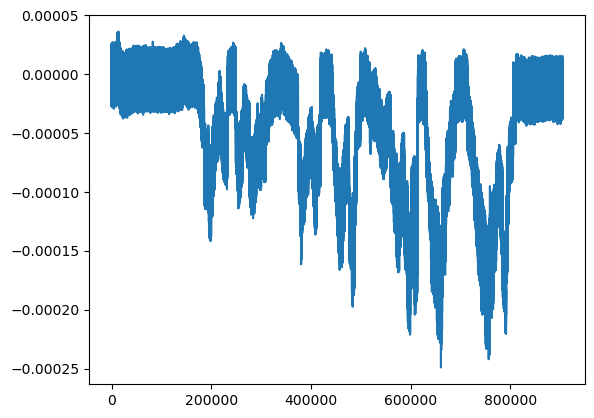

In [22]:
# Validation 1: check the accuracy of these factors in the non-sensible test
# (Day2Dynamic1)
# observed strain
test_date = "08_02_2022"
test_folder = "Day2_Dynamic1"
test_name = "normalized_WTRUN2_day2_dynamic1_2022-08-02_14-32-54-11_rtd-str_Jan2023"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=1)

sg_df_comp = add_compensated_data_to_df (sg_df, comp_factors, True)
plt.plot(sg_df_comp["SG 1 (V) (normalized) (compensated)"])


In [11]:
# Validation 2: Check the accuracy of these factors in the other non-sensible test
# (Day1Training1)
time_range = (datetime(2022,8,1,17,27,00), datetime(2022,8,1,17,42,50))
test_date = "08_01_2022"
test_folder = "Day1_Training1"

# lift
test_name = "flagged_DateTimed_WTRUN2_day1_training1_EDS"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
eds_csv = os.path.join(data_dir, test_name+".csv")
eds_df = pd.read_csv(eds_csv, header=0, index_col=False)
eds_df.insert(1, "Date/Time (formatted)", eds_df["DateTime Str"])
eds_df["Date/Time (formatted)"] = eds_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
eds_df_filtered = eds_df[(eds_df["Date/Time (formatted)"] > time_range[0]) & (eds_df["Date/Time (formatted)"] < time_range[1])]

ave_lift_nonsensible = np.mean(eds_df_filtered["Lift (lbf)"])
exp_str = ave_lift_nonsensible/lift_to_str_ratios

# observed strain
test_name = "normalized_WTRUN2_training_sweep1_2022-08-01_17-24-43-50_rtd-str_Jan2023"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=1)
sg_df.insert(1, "Date/Time (formatted)", sg_df["Date/Time"])
sg_df["Date/Time (formatted)"] = sg_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d_%H-%M-%S-%f"))
sg_df_comp = add_compensated_data_to_df (sg_df, comp_factors, True)

sg_df_comp_filtered = sg_df_comp[(sg_df_comp["Date/Time (formatted)"] > time_range[0]) & (sg_df_comp["Date/Time (formatted)"] < time_range[1])]
sg_df_comp_filtered_ave = np.mean(sg_df_comp_filtered["SG 1 (V) (normalized) (compensated)"])

In [13]:
print (exp_str)
print (sg_df_comp_filtered_ave)

SG 1   -0.000002
SG 2   -0.000008
SG 4   -0.000001
SG 5   -0.000003
SG 6    0.000003
dtype: float64
-5.031739424472903e-07


### Save the compensation factors for cooling.

In [23]:
data_name = "compfactors_Jan2023_cooling.pickle"

with open(os.path.join(compfactor_dir, data_name), 'wb') as f:
  pickle.dump(comp_factors, f)

# 3) Add Compensated Strains
The block below computes the compensated data and creates a new .csv file with them in it.

In [6]:
# Add compensation factors for heating
compfact_name = "compfactors_Jan2023_heating.pickle"

# test_date = "08_01_2022"
# test_folder = "preliminary"
# test_name = "normalized_heating_pretest_rtd-str_Jan2023"
test_date = "08_02_2022"
test_folder = "Day2_Training1"
test_name = "normalized_WTRUN2_day2_training1_2022-08-02_12-38-30-01_rtd-str_Jan2023"

data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=1)

with open(os.path.join(compfactor_dir, compfact_name), 'rb') as f:
  comp_factors = pickle.load(f)

sg_df_comp = add_compensated_data_to_df (sg_df, comp_factors, unique_rtds)

compensated_csv = os.path.join(data_dir, "compensated_"+test_name+"_tworegion.csv")
sg_df_comp.to_csv(compensated_csv, index=False)

Uniform filter applied to RTD 6.


In [27]:
# Add compensation factors for cooling
compfact_name = "compfactors_Jan2023_cooling.pickle"

# test_date = "08_01_2022"
# test_folder = "Day1_Training1"
# test_name = "normalized_WTRUN2_training_sweep1_2022-08-01_17-24-43-50_rtd-str_Jan2023"
test_date = "08_02_2022"
test_folder = "Day2_Dynamic1"
test_name = "normalized_WTRUN2_day2_dynamic1_2022-08-02_14-32-54-11_rtd-str_Jan2023"

data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=1)

with open(os.path.join(compfactor_dir, compfact_name), 'rb') as f:
  comp_factors = pickle.load(f)

test_df_comp = add_compensated_data_to_df (sg_df, comp_factors, unique_rtds)

compensated_csv = os.path.join(data_dir, "compensated_"+test_name+"_tworegion.csv")
test_df_comp.to_csv(compensated_csv, index=False)

Uniform filter applied to RTD 6.
